# Problem Set 2: CNNs & TensorFlow [75 pts]



**Note**: The following has been verified to work with TensorFlow 2.0

\* Adapted from official TensorFlow&trade; tour guide.

TensorFlow is a powerful library for doing large-scale numerical computation. One of the tasks at which it excels is implementing and training deep neural networks. In this assignment you will learn the basic building blocks of a TensorFlow model while constructing a deep convolutional MNIST classifier.

What you are expected to implement in this tutorial:

* Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image

* Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples

* Check the model's accuracy with MNIST test data

* Build, train, and test a multilayer convolutional neural network to improve the results


# Part 1: Coding [50 pts]

## Data

After importing tensorflow, we can download the MNIST dataset with the built-in TensorFlow/Keras method.

In [25]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'
tf.__version__

'2.3.0'

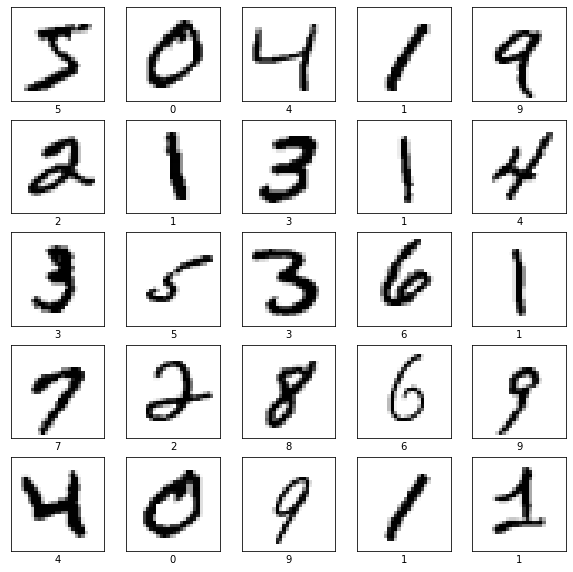

In [26]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the CNN

In this part we will build a customized TF2 Keras model. As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. For MNIST, you will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST images. You can do this by passing the argument input_shape to our first layer.

The overall architecture should be:

```
Model: "customized_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  7930880   
_________________________________________________________________
dense_3 (Dense)              multiple                  10250     
=================================================================
Total params: 7,959,946
Trainable params: 7,959,946
Non-trainable params: 0
_________________________________________________________________
```
### First Convolutional Layer [5 pts]

We can now implement our first layer. The convolution will compute 32 features for each 3x3 patch. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels.

### Max Pooling Layer [5 pts]

We stack max pooling layer after the first convolutional layer. These pooling layers will perform max pooling for each 2x2 patch.

### Second Convolutional Layer [5 pts]

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 3x3 patch.


### Fully Connected Layers [10 pts]

Now that the image size has been reduced to 11x11, we add a fully-connected layer with 128 neurons to allow processing on the entire image. We reshape the tensor from the second convolutional layer into a batch of vectors before the fully connected layer.

The output layer should also be implemented via a fully connect layer.


### Complete the Computation Graph [15 pts]

Please complete the following function:

```def call(self, inputs, training=None, mask=None):```

To apply the layer, we first reshape the input to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels (which is 1).

We then convolve the reshaped input with the first convolutional layer and then the max pooling followed by the second convolutional layer. These convolutional layers and the pooling layer will reduce the image size to 11x11.

### Dropout Layer [5 pts]
Please add dropouts during training before each fully connected layers, as this helps avoid overfitting during training.
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [27]:
class CustomizedCNN(tf.keras.models.Model):

    def __init__(self, *args, **kwargs):
        
        super(CustomizedCNN,self).__init__(*args, **kwargs)
        
        self.reshpOne = tf.keras.layers.Reshape((28, 28, 1))
        
        self.confirst = tf.keras.layers.Conv2D(32, (3,3), activation ='relu', input_shape=(28,28,1))
        
        self.mpoollayer = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        
        self.consecond = tf.keras.layers.Conv2D(64,(3,3), activation ='relu', input_shape=(28,28,1))
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.connect1 = tf.keras.layers.Dense(128, activation='relu') 
        
        self.connect2 = tf.keras.layers.Dense(10)
        
        self.dropout = tf.keras.layers.Dropout(0.5)
        
        

    def call(self, inputs, training=None, mask=None):
        
        inputs = self.reshpOne(inputs)
        
        inputs = tf.cast(inputs, tf.float16)
        
        confirst = self.confirst(inputs)
        
        mpoollayer = self.mpoollayer(confirst)
        
        consecond = self.consecond(mpoollayer)
        
        flatten = self.flatten(consecond)
        
        flatten = self.dropout(flatten)
        
        connect1 = self.connect1(flatten)
        
        connect1 = self.dropout(connect1)
        
        result = self.connect2(connect1)
        
        return result
        
    

## Build the Model

In [28]:
model = CustomizedCNN()
model.build(input_shape=(None, 28, 28))
model.summary()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "customized_cnn_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_12 (Conv2D)           multiple                  320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
____________________

We can specify a loss function just as easily. Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction. As in the beginners tutorial, we use the stable formulation:

In [29]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

## Train and Evaluate the Model [5 pts]

We will use a more sophisticated ADAM optimizer instead of a Gradient Descent Optimizer.

Feel free to run this code. Be aware that it does 10 training epochs and may take a while (possibly up to half an hour), depending on your processor.

The final test set accuracy after running this code should be approximately 98.7%  -- not state of the art, but respectable.

We have learned how to quickly and easily build, train, and evaluate a fairly sophisticated deep learning model using TensorFlow.

In [30]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels)) 

Epoch 1/10
1875/1875 [==============================] - 65s 35ms/step - loss: 0.4743 - accuracy: 0.8929 - val_loss: 0.0831 - val_accuracy: 0.9754
Epoch 2/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.1655 - accuracy: 0.9529 - val_loss: 0.0588 - val_accuracy: 0.9803
Epoch 3/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.1313 - accuracy: 0.9637 - val_loss: 0.0519 - val_accuracy: 0.9827
Epoch 4/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1127 - accuracy: 0.9676 - val_loss: 0.0457 - val_accuracy: 0.9855
Epoch 5/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.1039 - accuracy: 0.9708 - val_loss: 0.0499 - val_accuracy: 0.9844
Epoch 6/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0938 - accuracy: 0.9732 - val_loss: 0.0476 - val_accuracy: 0.9853
Epoch 7/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0869 - accuracy: 0.9752 - val_loss: 0.0526 -

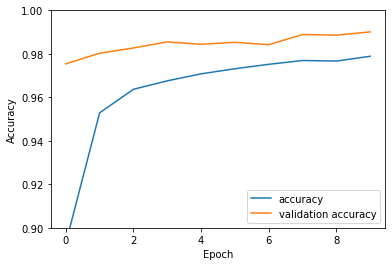

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

In [33]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)
print(test_acc)

313/313 [==============================] - 4s 11ms/step - loss: 0.0391 - accuracy: 0.9901
0.9901000261306763


# Part 2: Written [25 pts]


**2.1 [5pts]** Suppose we have a neural network with ReLU activation function. Let’s say, we replace ReLu activations by linear activations. Would this new neural network be able to approximate a non-linear function? And why? 

If ReLU activation is replaced by linear activation, the neural network loses its power to approximate non-linear function.

**2.2 [5pts]**  List two ways to downsize feature maps in convolutional neural networks.

1st:

Maxpooling layer. 

2nd:

Convolution Layers with increased strides

**2.3 [5pts]**  Describe K-fold cross-validation.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

**2.4 [5pts]**  List four techniques that help a model avoid overfitting. Briefly explain each in 2-3 sentences.

1. Simplifying The Model
 
The first step when dealing with overfitting is to decrease the complexity of the model. To decrease the complexity, we can simply remove layers or reduce the number of neurons to make the network smaller. While doing this, it is important to calculate the input and output dimensions of the various layers involved in the neural network. There is no general rule on how much to remove or how large your network should be. But, if your neural network is overfitting, try making it smaller.

2. Early Stopping
 
Early stopping is a form of regularization while training a model with an iterative method, such as gradient descent. Since all the neural networks learn exclusively by using gradient descent, early stopping is a technique applicable to all the problems. This method update the model so as to make it better fit the training data with each iteration. Up to a point, this improves the model’s performance on data on the test set. Past that point however, improving the model’s fit to the training data leads to increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the model begins to overfit.

3. Use Dropouts
 
Dropout is a regularization technique that prevents neural networks from overfitting. Regularization methods like L1 and L2 reduce overfitting by modifying the cost function. Dropout on the other hand, modify the network itself. It randomly drops neurons from the neural network during training in each iteration. When we drop different sets of neurons, it’s equivalent to training different neural networks. The different networks will overfit in different ways, so the net effect of dropout will be to reduce overfitting.

4. Use Data Augmentation
 
In the case of neural networks, data augmentation simply means increasing size of the data that is increasing the number of images present in the dataset. Some of the popular image augmentation techniques are flipping, translation, rotation, scaling, changing brightness, adding noise etcetera. 


**2.5 [5pts]** Read the following on convolutions: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1. What is padding? And what does it help us achieve.

Padding:  pads the edges with extra, “fake” pixels (usually of value 0, hence the oft-used term “zero padding”). This way, the kernel when sliding can allow the original edge pixels to be at its center, while extending into the fake pixels beyond the edge, producing an output the same size as the input.